In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import sys 
sys.path.append("../..")
import argparse
import logging
import math
import os
import random
from collections import namedtuple
from typing import Optional, Union
from multiscale_sde.util import softplus_inverse

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from tqdm.notebook import trange
from torch import distributions, nn, optim

import torchsde
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def manual_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

manual_seed(0)
plt.style.use('seaborn-poster')
import seaborn as sns 

/tmp/ipykernel_1860581/1386110681.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


In [3]:
import gpytorch
from gpytorch.kernels import RBFKernel, MaternKernel
# w/ underscore -> numpy; w/o underscore -> torch.
Data = namedtuple('Data', ['ts_', 'ts_ext_', 'ts_vis_', 'ts', 'ts_ext', 'ts_vis', 'ys', 'ys_'])
def make_irregular_gp_data():
    k = MaternKernel(nu=1.5)
    k.lengthscale = 1
    ts = np.concatenate(
        [
            np.random.uniform(low=0.1, high=0.5, size=5),
            np.random.uniform(low=1.5, high=1.9, size=5)
        ],
        axis=0
    )
    ts_ = np.sort(ts)
    ts_ext_ = np.array([0.] + list(ts_) + [2.0])
    ts_vis_ = np.linspace(0., 2.0, 300)
    K = k(torch.Tensor(ts_)).evaluate().double() + (1e-6*torch.eye(ts_.shape[0])).double()
    L = torch.linalg.cholesky(K)
    ys_ = L.detach().cpu().numpy() @ np.random.normal(size=(K.shape[0], 1)).astype(np.float64)

    ts = torch.tensor(ts_).float()
    ts_ext = torch.tensor(ts_ext_).float()
    ts_vis = torch.tensor(ts_vis_).float()
    ys = torch.tensor(ys_).float().to(device)
    return Data(ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_)

In [4]:
# generate data
ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_ = make_irregular_gp_data()

In [19]:
from torch.autograd import grad


# pick SDEInt
sdeint_fn = torchsde.sdeint

# pick model hyperparameters
method = "euler"
dt = 1e-2
adaptive = False 
rtol = 1e-3
atol = 1e-3

class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1, iters)
        self._val = maxval / self._iters
        self._maxval = maxval

    def step(self):
        self._val = min(self._maxval, self._val + self._maxval / self._iters)

    @property
    def val(self):
        return self._val

def _stable_division(a, b, epsilon=1e-7):
    b = torch.where(b.abs().detach() > epsilon, b, torch.full_like(b, fill_value=epsilon) * b.sign())
    return a / b

class LatentSDE(torchsde.SDEIto):

    def __init__(self, device="cpu"):
        super(LatentSDE, self).__init__(noise_type="diagonal")

        self.device = device

        # Approximate posterior drifts
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        # Prior drifts
        self.prior_net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
        # set prior and posterior initial conditions
        self.register_buffer("py0_mean", torch.zeros((1)))
        self.register_buffer("py0_std", torch.ones((1)))
        self.qy0_mean = nn.Parameter(torch.tensor([0.]), requires_grad=True)
        self.qy0_std_unconstrained = nn.Parameter(torch.tensor([1.]), requires_grad=True)
    @property
    def qy0_std(self):
        return nn.functional.softplus(self.qy0_std_unconstrained)

    def f(self, t, y):  # Approximate posterior drift.

        # neural networks with fourier time features
        # t = torch.full_like(y[:,:1], fill_value=t.item())
        # drift1 = self.net1(torch.cat((torch.sin(t), torch.cos(t), y[:, :1]), axis=1))
        # drift2 = self.net2(torch.cat((torch.sin(t), torch.cos(t), y), axis=1))
        
        # h(x) of an energy based model exp(-h(x))
        energy = self.net(y)
        # -grad(h(x))
        drift = -grad(energy.sum(), y, retain_graph=True)[0]
        return drift

    def f_prior(self, t, y):  # Prior drift.
        # h(x) of an energy based model exp(-h(x))
        energy = self.prior_net(y)
        # -grad(h(x))
        drift = -grad(energy.sum(), y, retain_graph=True)[0]
        return drift

        # return -y/2
    
    def g(self, t, y):  # Shared diffusion.
        """
        """
        # return self.sigma.repeat(y.size(0), 1)
        # drift matrix = sigma^2 * sqrt(2 / l) for Matern12 kernel (diffusion of BM is 2/l)
        return torch.ones(y.size(), device=self.device) * math.sqrt(2)

    def g_pure(self, t, y):  # Shared diffusion.
        """
        """
        # return self.sigma.repeat(y.size(0), 1)
        # drift matrix = sigma^2 * sqrt(2 / l) for Matern12 kernel (diffusion of BM is 2/l)
        return torch.ones(y.size(), device=self.device) * math.sqrt(2)

    def f_aug(self, t, y):  # Drift for augmented dynamics with logqp term.
        y = y[:,:-1]
        f, g, f_prior = self.f(t, y), self.g(t, y), self.f_prior(t, y)
        u = _stable_division(f - f_prior, g)
        f_logqp = .5 * (u ** 2).sum(dim=1, keepdim=True)
        return torch.cat([f, f_logqp], dim=1)

    def g_aug(self, t, y):  # Diffusion for augmented dynamics with logqp term.
        y = y[:,:-1]
        g = self.g(t, y)
        g_logqp = torch.zeros_like(y[:,:1])
        return torch.cat([g, g_logqp], dim=1)

    def forward(self, ts, batch_size, eps=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_std) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        qy0 = distributions.Normal(loc=self.qy0_mean, scale=self.qy0_std)
        py0 = distributions.Normal(loc=self.py0_mean, scale=self.py0_std)
        logqp0 = distributions.kl_divergence(qy0, py0) # KL(t=0).

        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)
        aug_ys = sdeint_fn(
            sde=self,
            y0=aug_y0,
            ts=ts,
            method=method,
            dt=dt,
            adaptive=adaptive,
            rtol=rtol,
            atol=atol,
            names={'drift': 'f_aug', 'diffusion': 'g_aug'}
        )
        ys, logqp_path = aug_ys[:, :, :2], aug_ys[-1, :, -1]
        logqp = logqp0.sum() + logqp_path.mean(dim=0)  # KL(t=0) + KL(path).
        return ys, logqp

    def sample_p(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.py0_mean) if eps is None else eps
        y0 = self.py0_mean + eps * self.py0_std
        
        yt = sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=dt, names={'drift': 'f_prior'})
        return yt

    def sample_q(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_mean) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        yt = sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=dt, names={"drift" : "f"})
        return yt

    def sample_qinf(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_mean) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        yt = sdeint_fn(self, y0, ts, bm=bm, method='euler', dt=dt, names={"drift" : "f", "diffusion": "g_pure"})
        return yt

In [20]:
model = LatentSDE(device=device).to(device)
# test forward
# y_forward, kl = model.forward(ts, batch_size=5)
# print(y_forward.shape, kl)

# # test sample_p
# print(model.f_prior(ts, ys).shape, model.g(ts, ys).shape)
# print(model.sample_p(ts, batch_size=5).shape)

# # test sample_q
# print(model.f(ts, ys).shape, model.g(ts, ys).shape)
# posterior_samples = model.sample_q(ts, batch_size=128)
# print(posterior_samples.shape)

## Training

In [27]:
model.train()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=.999)
kl_scheduler = LinearScheduler(iters=100)

iterator = trange(300)
for global_step in tqdm.tqdm(range(300)):
        optimizer.zero_grad()
        zs, kl = model(ts=ts_ext, batch_size=128)
        zs = zs.squeeze()[1:-1]
        # zs = zs[1:-1]  # Drop first and last which are only used to penalize out-of-data region and spread uncertainty.
        likelihood_constructor = distributions.Normal
        likelihood = likelihood_constructor(loc=zs, scale=0.01)
        logpy = likelihood.log_prob(ys[:,None,:]).sum(dim=[0,-1]).mean(dim=0)
        loss = -logpy + kl * kl_scheduler.val
        loss.backward()

        iterator.set_description(
            f"EPOCH {i}, ELBO: {loss.item():1.4f}"
        )
        optimizer.step()
        scheduler.step()
        kl_scheduler.step()

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

## Plotting

Text(0.5, 0, 'Time $t$')

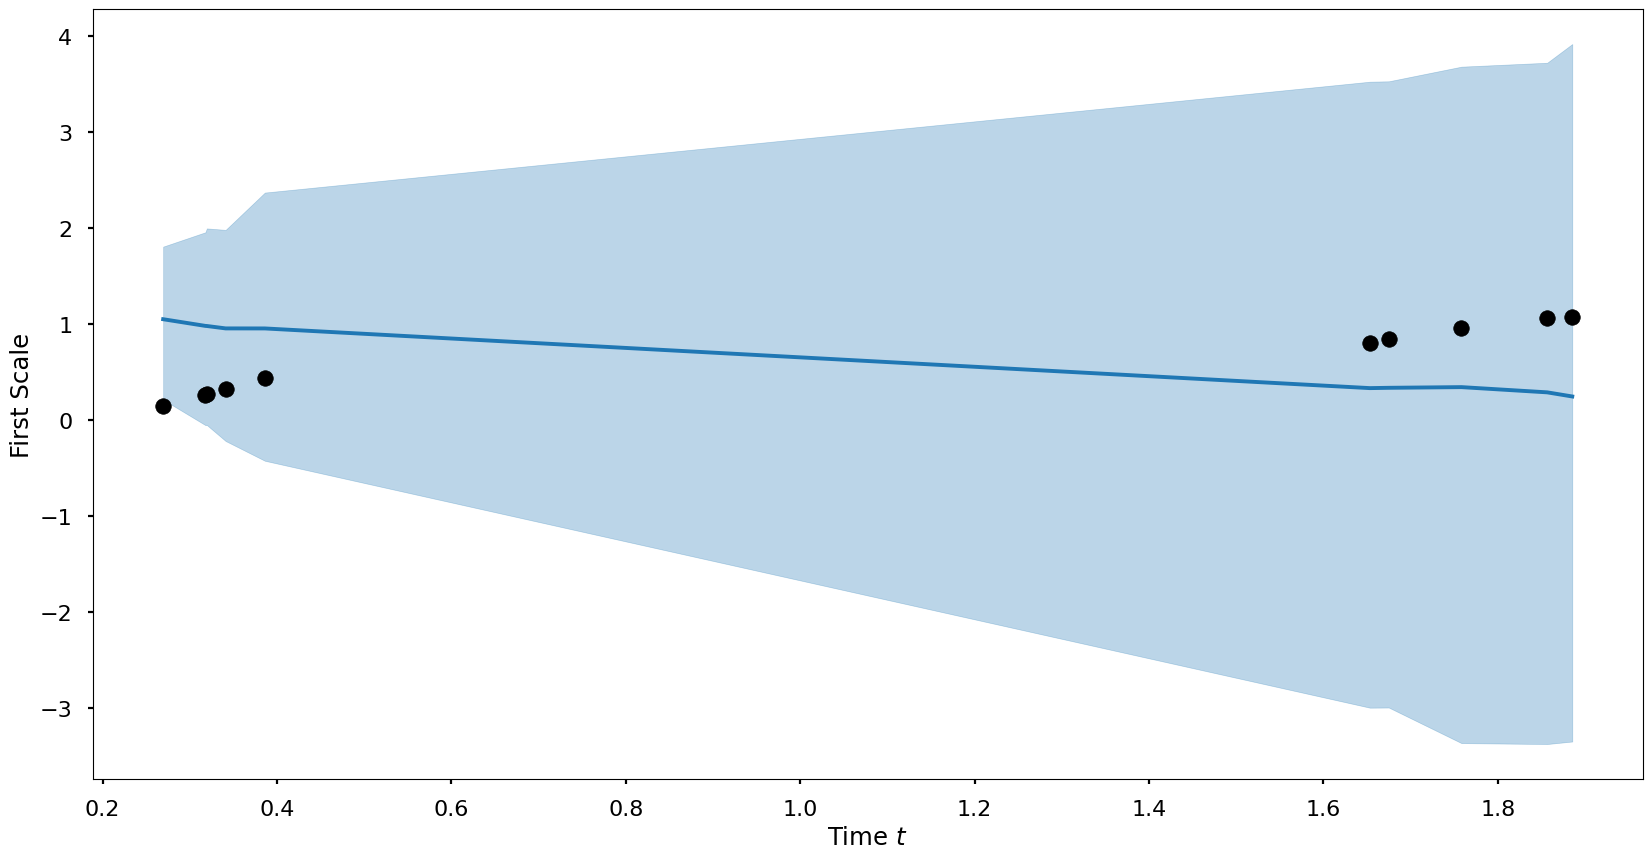

In [23]:
model.eval()
posterior_samples = model.sample_q(ts, batch_size=128)
y_pred_plot = posterior_samples.cpu().detach().numpy()
y_pred = posterior_samples.mean(1).cpu().detach().numpy()
fig = plt.figure(frameon=False, figsize=(20,10))
plt.plot(ts_, y_pred[:,0], color="C0")

# plot the credible interval
y_pred_plot[:,:,0] = np.sort(y_pred_plot[:,:,0], axis=1)
percentile = 0.95
idx = int((1 - percentile) / 2. * y_pred_plot.shape[1])
y_pred_plot_bottom, y_pred_plot_top = y_pred_plot[:, idx,0], y_pred_plot[:, -idx,0]
plt.fill_between(ts_, y_pred_plot_bottom, y_pred_plot_top, alpha=0.3, color="C0")

plt.scatter(ts_, ys_[:,0], color="black")
plt.ylabel("First Scale")
plt.xlabel("Time $t$")

## Generate stationary samples with SGLD

In [11]:
model.eval()
# make 100 steps of Euler method
ts_gen = torch.Tensor([0, 50*dt, 100*dt, dt*500])

In [12]:
qinf_samples = model.sample_qinf(ts_gen, batch_size=512)
qinf_samples_ = qinf_samples.detach().cpu().numpy()[:,:,0]

In [13]:
qinf_samples_.shape, qinf_samples.shape

((4, 512), torch.Size([4, 512, 1]))

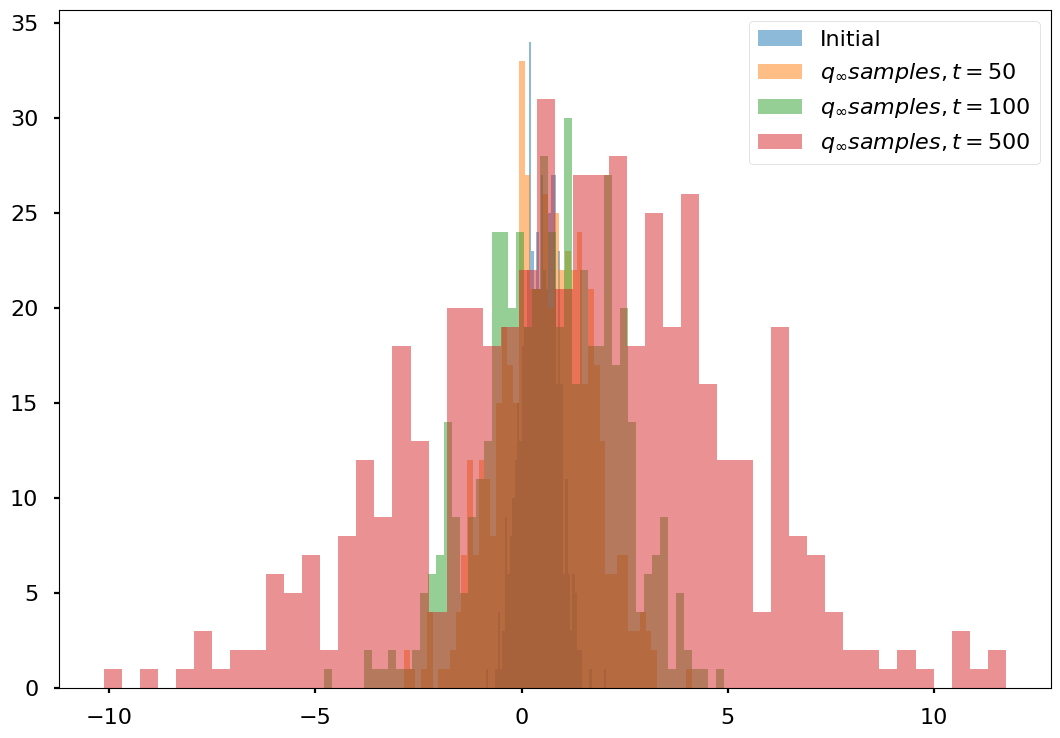

In [14]:
plt.hist(qinf_samples_[0], bins=50, alpha=0.5, label="Initial")
plt.hist(qinf_samples_[1], bins=50, alpha=0.5, label="$q_\infty samples, t=50$")
plt.hist(qinf_samples_[2], bins=50, alpha=0.5, label="$q_\infty samples, t=100$")
plt.hist(qinf_samples_[3], bins=50, alpha=0.5, label="$q_\infty samples, t=500$")
plt.legend()